GENE TO DISEASE NAME GENERATOR USING DL & NLP

In [1]:
import pandas as pd
import re
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import top_k_accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv(r"C:\Users\shiva\Documents\codes\IIIT - VT\DNA_VT_FINAL_PROJECT\cleaned_gene_cond.csv", header=0)

print(df.head())
print(df.columns)

  GeneID,AssociatedGenes,RelatedGenes,ConceptID,DiseaseName,SourceName,SourceID,DiseaseMIM,LastUpdated
0  144568,A2ML1,C1833692,Otitis,"media, susceptib...                                                  
1  53947,A4GALT,C3549485,Blood,"group, P1PK syste...                                                  
2  8086,AAAS,C0271742,Glucocorticoid,deficiency w...                                                  
3  79719,AAGAB,CN031225,Palmoplantar,"keratoderma...                                                  
4  16,AARS1,C4225361,Developmental,"and epileptic...                                                  
Index(['GeneID,AssociatedGenes,RelatedGenes,ConceptID,DiseaseName,SourceName,SourceID,DiseaseMIM,LastUpdated'], dtype='object')


In [3]:
# columns = ['Name','Roll', 'Age' , "Gender" ,"Address" ]
# data_list = data.values.flatten().tolist()
# records = [data_list[i:i+5] for i in range(0, len(data_list), 5)] #dividing data into chunks of 5
# df = pd.DataFrame(records, columns=columns)

In [4]:
raw_data = pd.read_csv("cleaned_gene_cond.csv", header=None)

# use regex to split on commas NOT inside quotes
# to avoid splitting gene names with commas in them
pattern = r''',(?=(?:[^"]*"[^"]*")*[^"]*$)'''

# apply to each row
records = raw_data[0].apply(lambda x: re.split(pattern, x)).tolist()

# convert to DataFrame
data = pd.DataFrame(records)

# set correct column names
data.columns = [
    'GeneID', 'AssociatedGenes', 'RelatedGenes', 'ConceptID',
    'DiseaseName', 'SourceName', 'SourceID', 'DiseaseMIM', 'LastUpdated'
]

# remove first row if duplicate header
if data.iloc[0,0] == 'GeneID':
    data = data.iloc[1:]

# remove extra quotes
data = data.apply(lambda x: x.str.replace('"','').str.strip())
data.to_csv("cleaned_data.csv", index=False)
# preview
print(data.head())
print(data.columns)


   GeneID AssociatedGenes RelatedGenes       ConceptID  \
1  144568           A2ML1     C1833692          Otitis   
2   53947          A4GALT     C3549485           Blood   
3    8086            AAAS     C0271742  Glucocorticoid   
4   79719           AAGAB     CN031225    Palmoplantar   
5      16           AARS1     C4225361   Developmental   

                        DiseaseName SourceName       SourceID DiseaseMIM  \
1          media, susceptibility to      MONDO  MONDO:0008162     166760   
2                group, P1PK system       NCBI       curation     111400   
3         deficiency with achalasia       NCBI       curation     231550   
4     keratoderma, punctate type 1A      MONDO  MONDO:0007858     148600   
5  and epileptic encephalopathy, 29      MONDO  MONDO:0014593     616339   

   LastUpdated  
1  Feb 16 2016  
2  Mar 10 2022  
3  Feb 16 2016  
4  May 21 2021  
5  Jan 21 2022  
Index(['GeneID', 'AssociatedGenes', 'RelatedGenes', 'ConceptID', 'DiseaseName',
       'Sour

In [5]:
print("Missing values in each column:")
print(data.isna().sum())

#standardize column names
data['DiseaseName'] = data['DiseaseName'].str.strip().str.lower()
data['AssociatedGenes'] = data['AssociatedGenes'].str.strip().str.upper()

#convert LastUpdated to datetime
data['LastUpdated'] = pd.to_datetime(data['LastUpdated'], errors='coerce')



Missing values in each column:
GeneID             0
AssociatedGenes    0
RelatedGenes       0
ConceptID          0
DiseaseName        0
SourceName         0
SourceID           0
DiseaseMIM         0
LastUpdated        0
dtype: int64


In [6]:
print(data.head())
print(data.info())

   GeneID AssociatedGenes RelatedGenes       ConceptID  \
1  144568           A2ML1     C1833692          Otitis   
2   53947          A4GALT     C3549485           Blood   
3    8086            AAAS     C0271742  Glucocorticoid   
4   79719           AAGAB     CN031225    Palmoplantar   
5      16           AARS1     C4225361   Developmental   

                        DiseaseName SourceName       SourceID DiseaseMIM  \
1          media, susceptibility to      MONDO  MONDO:0008162     166760   
2                group, p1pk system       NCBI       curation     111400   
3         deficiency with achalasia       NCBI       curation     231550   
4     keratoderma, punctate type 1a      MONDO  MONDO:0007858     148600   
5  and epileptic encephalopathy, 29      MONDO  MONDO:0014593     616339   

  LastUpdated  
1  2016-02-16  
2  2022-03-10  
3  2016-02-16  
4  2021-05-21  
5  2022-01-21  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10069 entries, 1 to 10069
Data columns (total 9 

STEP 2 : EDA

In [7]:
print("Checking Unique Values:")
print("Unique Disease Name: ",data['DiseaseName'].nunique())
print("Unique Associated Genes: ",data['AssociatedGenes'].nunique())
print("Top 10 Most Frequent Disease Names:\n", data['DiseaseName'].value_counts().head(10))

print("Rows with AssociatedGenes == 'unknown':\n", data[data['AssociatedGenes'] == 'unknown'])

print("Rows with DiseaseName == 'unknown':\n", data[data['DiseaseName'] == 'unknown'])

print("LastUpdated Range: ", data['LastUpdated'].min(), "to", data['LastUpdated'].max())




Checking Unique Values:
Unique Disease Name:  5562
Unique Associated Genes:  4881
Top 10 Most Frequent Disease Names:
 DiseaseName
syndrome                     706
                             376
disease                      231
disorder of glycosylation    103
muscular dystrophy            89
genetic hearing loss          87
syndrome 1                    77
response                      75
pigmentosa                    74
cancer                        71
Name: count, dtype: int64
Rows with AssociatedGenes == 'unknown':
 Empty DataFrame
Columns: [GeneID, AssociatedGenes, RelatedGenes, ConceptID, DiseaseName, SourceName, SourceID, DiseaseMIM, LastUpdated]
Index: []
Rows with DiseaseName == 'unknown':
 Empty DataFrame
Columns: [GeneID, AssociatedGenes, RelatedGenes, ConceptID, DiseaseName, SourceName, SourceID, DiseaseMIM, LastUpdated]
Index: []
LastUpdated Range:  2016-02-16 00:00:00 to 2025-05-28 00:00:00


In [8]:
print("Random Sample of 5 Rows:\n", data.sample(5))


Random Sample of 5 Rows:
      GeneID AssociatedGenes RelatedGenes           ConceptID  \
39      368           ABCC6     C3276161            Arterial   
8924   4624            MYH6     C0878544      Cardiomyopathy   
1285   1303         COL12A1     C4225313             Bethlem   
2712   8443           GNPAT     C1857242          Rhizomelic   
2088  90952            ESAM     C5830509  Neurodevelopmental   

                                            DiseaseName SourceName  \
39            calcification, generalized, of infancy, 2      MONDO   
8924                                                         MONDO   
1285                                         myopathy 2      MONDO   
2712                   chondrodysplasia punctata type 2      MONDO   
2088  disorder with intracranial hemorrhage, seizure...      MONDO   

           SourceID DiseaseMIM LastUpdated  
39    MONDO:0013768     614473  2022-04-19  
8924  MONDO:0004994         16         NaT  
1285  MONDO:0034022     616471  2

In [9]:
print(data["DiseaseName"].head(20))

1                              media, susceptibility to
2                                    group, p1pk system
3                             deficiency with achalasia
4                         keratoderma, punctate type 1a
5                      and epileptic encephalopathy, 29
6                  hereditary diffuse, with spheroids 2
7                                disease axonal type 2n
8                                  8, nonphotosensitive
9                     progressive, with ovarian failure
10              oxidative phosphorylation defect type 8
11                                                     
12                                              disease
13                                           primary, 1
14                   recessive congenital ichthyosis 4b
15                   recessive congenital ichthyosis 4a
16    developmental disorder with poor growth and wi...
17                 lung disease due to abca3 deficiency
18                                        pigmen

CLASSIFIER

In [10]:
# combine columns into one input feature
data['combined_text'] = (
    data['GeneID'].astype(str) + ' ' +
    data['AssociatedGenes'].astype(str) + ' ' +
    data['RelatedGenes'].astype(str)
)

# define X and y
x = data['combined_text']
y = data['DiseaseName']


In [11]:
# count frequency of each disease name
disease_counts = data['DiseaseName'].value_counts()

# filter to keep only disease names with at least 2 samples
# small classes will not be useful for training
valid_diseases = disease_counts[disease_counts >= 2].index
filtered_data = data[data['DiseaseName'].isin(valid_diseases)].copy()

print(f"Classes retained: {len(valid_diseases)}")




Classes retained: 658


In [12]:
# recompute X and y
filtered_data['combined_text'] = (
    filtered_data['GeneID'].astype(str) + ' ' +
    filtered_data['AssociatedGenes'].astype(str) + ' ' +
    filtered_data['RelatedGenes'].astype(str)
)
x = filtered_data['combined_text']
y = filtered_data['DiseaseName']



In [13]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# train/test split
x_train, x_test, y_train, y_test = train_test_split(
    x, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [14]:
print(x_train.shape, y_train.shape)
print(le.classes_[:5])


(4132,) (4132,)
['' '1' '10' '11' '12']


TOKENIZATION AND PADDING

In [15]:
# set max vocab size
vocab_size = 10000
maxlen = 20  # max length of the combined_text sequence

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)

# convert to sequences
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# pad
x_train_pad = pad_sequences(x_train_seq, maxlen=maxlen, padding='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=maxlen, padding='post')

print(x_train_pad.shape, x_test_pad.shape)

(4132, 20) (1033, 20)


In [16]:
model = Sequential([
    Embedding(vocab_size, 128, input_length=maxlen),
    LSTM(64),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model.summary()

c:\Users\shiva\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [17]:
history = model.fit(
    x_train_pad, y_train,
    validation_data=(x_test_pad, y_test),
    epochs=10,
    batch_size=32
)


Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.1189 - loss: 5.9063 - val_accuracy: 0.1365 - val_loss: 5.1985
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.1451 - loss: 5.1850 - val_accuracy: 0.1365 - val_loss: 5.1968
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.1407 - loss: 5.1910 - val_accuracy: 0.1365 - val_loss: 5.1752
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.1400 - loss: 5.1928 - val_accuracy: 0.1365 - val_loss: 5.1761
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.1339 - loss: 5.2367 - val_accuracy: 0.1365 - val_loss: 5.1756
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1375 - loss: 5.2073 - val_accuracy: 0.1365 - val_loss: 5.1764
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1419 - loss: 5.1718 - val_accuracy: 0.1365 - val_loss: 5.1749
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.1269 - loss: 5.2504 - val_accu

In [18]:
# get raw predictions (probabilities)
probs = model.predict(x_test_pad)

# get top-1 class
pred_classes = np.argmax(probs, axis=1)

# decode to disease names
pred_diseases = le.inverse_transform(pred_classes)

# show a few:
for i in range(6):
    print(f"Input: {x_test.iloc[i]}")
    print(f"True:  {le.inverse_transform([y_test[i]])[0]}")
    print(f"Pred:  {pred_diseases[i]}")
    print("---")

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Input: 6444 SGCD C0340427
True:  familial dilated cardiomyopathy
Pred:  syndrome
---
Input: 7291 TWIST1 C0175699
True:  syndrome
Pred:  syndrome
---
Input: 7015 TERT C0265965
True:  congenita
Pred:  syndrome
---
Input: 2719 GPC3 C0796154
True:  syndrome type 1
Pred:  syndrome
---
Input: 1141 CHRNB2 C3696898
True:  dominant nocturnal frontal lobe epilepsy
Pred:  syndrome
---
Input: 348 APOE C0002395
True:  disease
Pred:  syndrome
---


In [19]:
all_classes = np.arange(len(le.classes_))

print(classification_report(y_test, pred_classes, labels=all_classes, zero_division=0))

print("Top-3 accuracy: ", top_k_accuracy_score(y_test, probs, k=3, labels=all_classes))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

In [20]:
print("Sample true labels:", y_test[:10])
print("Sample predicted labels:", pred_classes[:10])
print("Label encoder classes:", le.classes_)
# Model's not learning meaningful patterns (Majority class prediction/ Class Imbalance)
# 1.Use class weights to handle class imbalance
# 2.Reduce the number of classes

Sample true labels: [254 548 124 574 202 169 114 548 564 433]
Sample predicted labels: [548 548 548 548 548 548 548 548 548 548]
Label encoder classes: ['' '1' '10' '11' '12' '13' '14' '15' '15q13.3 microdeletion syndrome'
 '16' '18' '19' '1q21.1 deletion syndrome' '2' '2 diabetes mellitus' '23'
 '25' '27' '3' '3 nonsyndromic hearing loss and deafness'
 '3, primary infantile, b' '30' '33' '36' '4' '45' '49' '5' '6' '7' '8'
 '9' 'acid lipase deficiency' 'acid storage disease' 'acidemia' 'aciduria'
 'aciduria and homocystinuria' 'acyl-coa dehydrogenase deficiency'
 'addiction, susceptibility to' 'adenomatous polyposis 1'
 'adhesion deficiency' 'adrenal hyperplasia' 'afibrinogenemia'
 'agenesis-abnormal ossification of the vertebral bodies-persistent notochordal canal syndrome'
 'albinism' 'albinism type 1' 'albinism type 7' 'alport syndrome'
 'amegakaryocytic thrombocytopenia' 'amyloid neuropathy' 'amyloidosis'
 'amyotrophic lateral sclerosis' 'and chorioretinopathy'
 'and lange-nielsen 

Using Weights

In [21]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

model.fit(
    x_train_pad, y_train,
    validation_data=(x_test_pad, y_test),
    epochs=10,
    batch_size=32,
    class_weight=class_weights_dict
)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.0681 - loss: 6.7184 - val_accuracy: 0.0000e+00 - val_loss: 6.6608
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.0011 - loss: 6.5205 - val_accuracy: 9.6805e-04 - val_loss: 6.5855
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 7.6346e-05 - loss: 6.5636 - val_accuracy: 9.6805e-04 - val_loss: 6.5443
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0013 - loss: 6.2200 - val_accuracy: 9.6805e-04 - val_loss: 6.5379
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0000e+00 - loss: 6.5770 - val_accuracy: 9.6805e-04 - val_loss: 6.5099
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 4.6841e-04 - loss: 6.2270 - val_accuracy: 9.6805e-04 - val_loss: 6.5084
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0000e+00 - loss: 6.4278 - val_accuracy: 9.6805e-04 - val_loss: 6.4989
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step 

In [22]:
# Get predictions on the test set
probs = model.predict(x_test_pad)
pred_classes = np.argmax(probs, axis=1)

# Evaluate performance
from sklearn.metrics import classification_report, top_k_accuracy_score

all_classes = np.arange(len(le.classes_))
print(classification_report(y_test, pred_classes, labels=all_classes, zero_division=0))
print("Top-3 accuracy: ", top_k_accuracy_score(y_test, probs, k=3, labels=all_classes))

# Optionally, inspect a few predictions
for i in range(5):
    print(f"Input: {x_test.iloc[i]}")
    print(f"True:  {le.inverse_transform([y_test[i]])[0]}")
    print(f"Pred:  {le.inverse_transform([pred_classes[i]])[0]}")
    print("---")

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.0

2. BROAD DISEASE CATEGORY CLASSIFICATION

In [23]:
# Map cluster ID to your custom labels
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd

# Step 1: Prepare the disease name text
text_data = data['DiseaseName'].fillna("")

# Step 2: Vectorize using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(text_data)

# Step 3: Apply KMeans clustering
kmeans = KMeans(n_clusters=15, random_state=42)
data['Cluster'] = kmeans.fit_predict(X)

# Step 4: Map cluster IDs to category labels
cluster_to_category = {
    0: "Sensory - Microphthalmia",
    1: "Generic Syndrome",
    2: "Other",
    3: "Storage/Metabolic",
    4: "Neurological - Susceptibility",
    5: "Reproductive",
    6: "Musculoskeletal - Dystrophy",
    7: "Metabolic Deficiencies",
    8: "Neurological - Epilepsy",
    9: "Respiratory - Ciliary Dyskinesia",
    10: "Cardiovascular - Cardiomyopathies",
    11: "Sensory - Hearing Loss",
    12: "Skeletal Disorders",
    13: "Myopathies",
    14: "Mitochondrial / Metabolic"
}

# Step 5: Create human-readable labels
data['ClusterCategory'] = data['Cluster'].map(cluster_to_category)

# Optional: Preview the result
print(data[['DiseaseName', 'Cluster', 'ClusterCategory']].head())




                        DiseaseName  Cluster   ClusterCategory
1          media, susceptibility to        1  Generic Syndrome
2                group, p1pk system        1  Generic Syndrome
3         deficiency with achalasia        1  Generic Syndrome
4     keratoderma, punctate type 1a       13        Myopathies
5  and epileptic encephalopathy, 29        1  Generic Syndrome


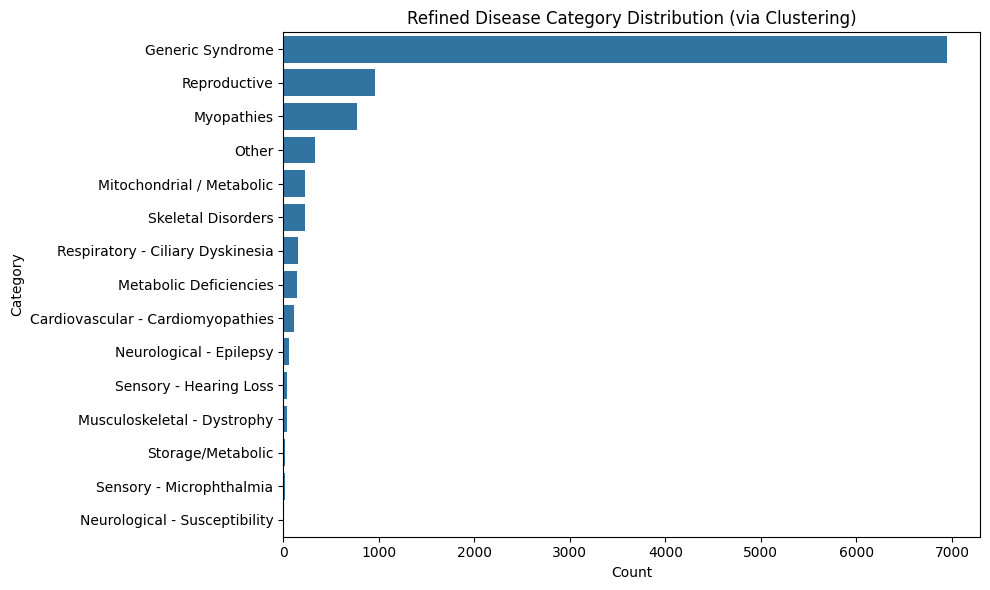

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(y=data["ClusterCategory"], order=data["ClusterCategory"].value_counts().index)
plt.title("Refined Disease Category Distribution (via Clustering)")
plt.xlabel("Count")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


In [25]:
# Use refined cluster-based categories for training
x = data['combined_text']
y = data['ClusterCategory']  # This now has more meaningful categories

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Tokenize and pad
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_train_pad = pad_sequences(x_train_seq, maxlen=maxlen, padding='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=maxlen, padding='post')


In [26]:
num_classes = len(le.classes_)  # Important: matches the number of cluster categories

model = Sequential([
    Embedding(vocab_size, 128, input_length=maxlen),
    LSTM(64),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

c:\Users\shiva\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
history = model.fit(
    x_train_pad, y_train,
    validation_data=(x_test_pad, y_test),
    epochs=10,
    batch_size=16
)


Epoch 1/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6864 - loss: 1.3605 - val_accuracy: 0.6897 - val_loss: 1.2467
Epoch 2/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6866 - loss: 1.2488 - val_accuracy: 0.6991 - val_loss: 1.1125
Epoch 3/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7403 - loss: 0.9861 - val_accuracy: 0.7413 - val_loss: 0.9489
Epoch 4/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7943 - loss: 0.7590 - val_accuracy: 0.7259 - val_loss: 0.9462
Epoch 5/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8458 - loss: 0.6007 - val_accuracy: 0.7453 - val_loss: 0.9421
Epoch 6/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8558 - loss: 0.5398 - val_accuracy: 0.7562 - val_loss: 0.9268
Epoch 7/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8739 - loss: 0.4796 - val_accuracy: 0.7547 - val_loss: 1.0462
Epoch 8/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8756 - loss: 0.4633 - val_accu

In [28]:
# Predict probabilities
probs = model.predict(x_test_pad)
pred_classes = np.argmax(probs, axis=1)

# Classification report
print(classification_report(y_test, pred_classes, target_names=le.classes_))

# Top-3 accuracy
print("Top-3 accuracy: ", top_k_accuracy_score(y_test, probs, k=3))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
                                   precision    recall  f1-score   support

Cardiovascular - Cardiomyopathies       0.68      0.57      0.62        23
                 Generic Syndrome       0.82      0.93      0.87      1389
           Metabolic Deficiencies       0.89      0.57      0.70        28
        Mitochondrial / Metabolic       1.00      0.04      0.08        46
      Musculoskeletal - Dystrophy       0.75      0.38      0.50         8
                       Myopathies       0.20      0.21      0.20       155
          Neurological - Epilepsy       1.00      0.50      0.67        12
    Neurological - Susceptibility       0.00      0.00      0.00         2
                            Other       0.89      0.83      0.86        66
                     Reproductive       0.82      0.44      0.57       193
 Respiratory - Ciliary Dyskinesia       0.72      0.58      0.64        31
           Sensory - Hearing Loss       0.50      0.22      

c:\Users\shiva\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shiva\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shiva\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [29]:
top_3_indices = np.argsort(probs, axis=1)[:, -3:][:, ::-1]  # Top 3

for i in range(5):
    input_text = x_test.iloc[i]
    true_label = le.inverse_transform([y_test[i]])[0]

    pred_probs = probs[i]
    top_k = np.argsort(pred_probs)[-3:][::-1]  # top 3 indices
    top_k_probs = pred_probs[top_k]
    top_k_labels = le.inverse_transform(top_k)

    print(f"Input: {input_text}")
    print(f"True Category: {true_label}")
    print("Top-3 Predictions:")
    for j in range(3):
        print(f"  {j+1}. {top_k_labels[j]} (Prob: {top_k_probs[j]:.3f})")

    # 🔎 If confidence gap is small
    if top_k_probs[0] - top_k_probs[1] < 0.1:
        print(f"⚠️ Model unsure between: {top_k_labels[0]} and {top_k_labels[1]}")

    print("-" * 50)


Input: 51524 TMEM138 C3280906
True Category: Generic Syndrome
Top-3 Predictions:
  1. Myopathies (Prob: 0.973)
  2. Sensory - Microphthalmia (Prob: 0.017)
  3. Reproductive (Prob: 0.005)
--------------------------------------------------
Input: 5593 PRKG2 C5562030
True Category: Skeletal Disorders
Top-3 Predictions:
  1. Generic Syndrome (Prob: 0.383)
  2. Skeletal Disorders (Prob: 0.223)
  3. Mitochondrial / Metabolic (Prob: 0.220)
--------------------------------------------------
Input: 2523 FUT1 C1859408
True Category: Generic Syndrome
Top-3 Predictions:
  1. Generic Syndrome (Prob: 0.997)
  2. Myopathies (Prob: 0.002)
  3. Sensory - Microphthalmia (Prob: 0.000)
--------------------------------------------------
Input: 5378 PMS1 C2936783
True Category: Reproductive
Top-3 Predictions:
  1. Reproductive (Prob: 0.995)
  2. Myopathies (Prob: 0.002)
  3. Skeletal Disorders (Prob: 0.001)
--------------------------------------------------
Input: 3119 HLA-DQB1 C0022336
True Category: Other

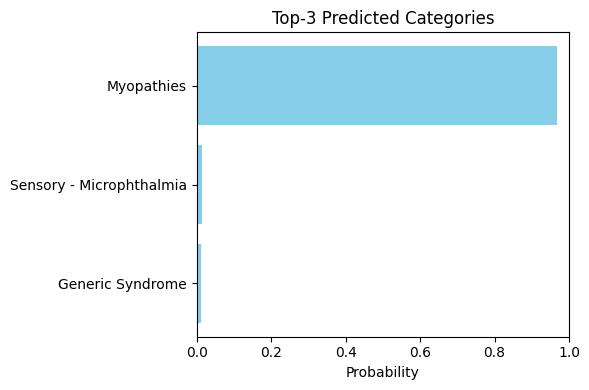

In [30]:

i = 50  # Choose any sample
top_3 = top_3_indices[i]
top_3_probs = probs[i][top_3]
top_3_labels = [le.classes_[j] for j in top_3]

plt.figure(figsize=(6, 4))
plt.barh(top_3_labels[::-1], top_3_probs[::-1], color='skyblue')
plt.xlabel("Probability")
plt.title("Top-3 Predicted Categories")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


### Training and validation accuracy and loss graph per epoch

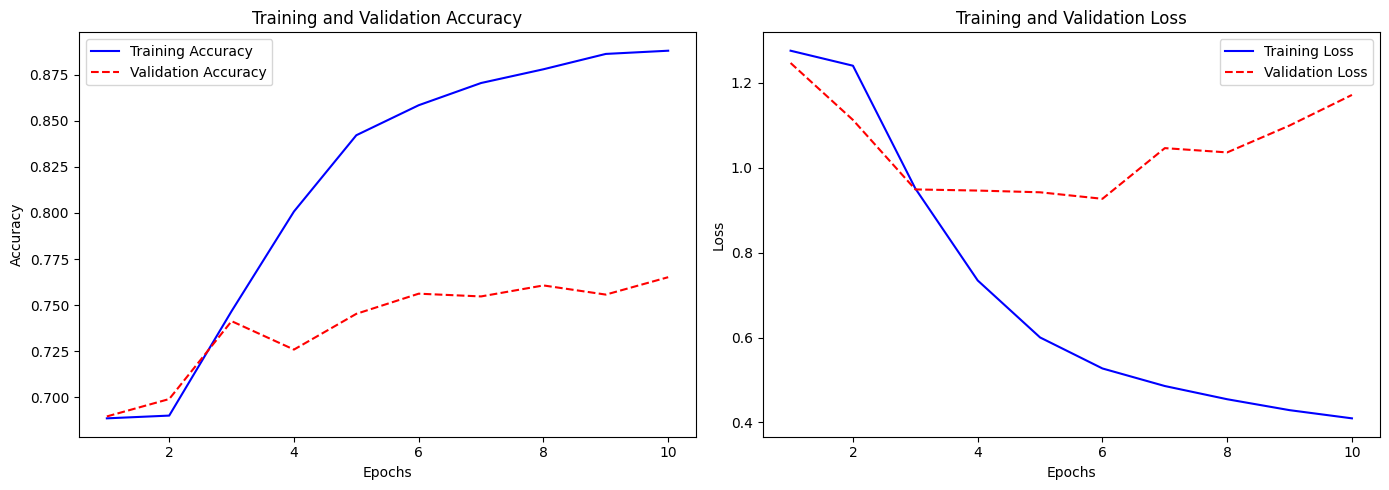

In [31]:
import matplotlib.pyplot as plt

# Assuming you have `history` from model.fit(...)
def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call this after training
plot_training_curves(history)


### Confusion matrix

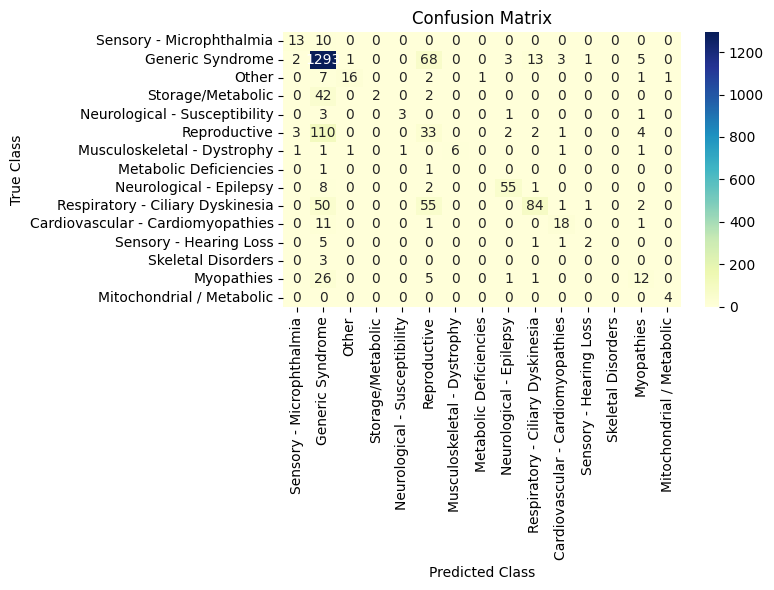

In [39]:


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Your actual class names (change these based on your dataset)
class_names = [
    "Sensory - Microphthalmia",
    "Generic Syndrome",
    "Other",
    "Storage/Metabolic",
    "Neurological - Susceptibility",
    "Reproductive",
    "Musculoskeletal - Dystrophy",
    "Metabolic Deficiencies",
    "Neurological - Epilepsy",
    "Respiratory - Ciliary Dyskinesia",
    "Cardiovascular - Cardiomyopathies",
    "Sensory - Hearing Loss",
    "Skeletal Disorders",
    "Myopathies",
    "Mitochondrial / Metabolic"
]  # Replace with your real labels

# y_test → true labels (encoded)
# y_pred → predicted labels (encoded)

# Create confusion matrix
cm = confusion_matrix(y_test, pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
#plt.xticks(rotation=45)
#plt.yticks(rotation=45)
plt.tight_layout()
plt.show()



### AUC-ROC Curve

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


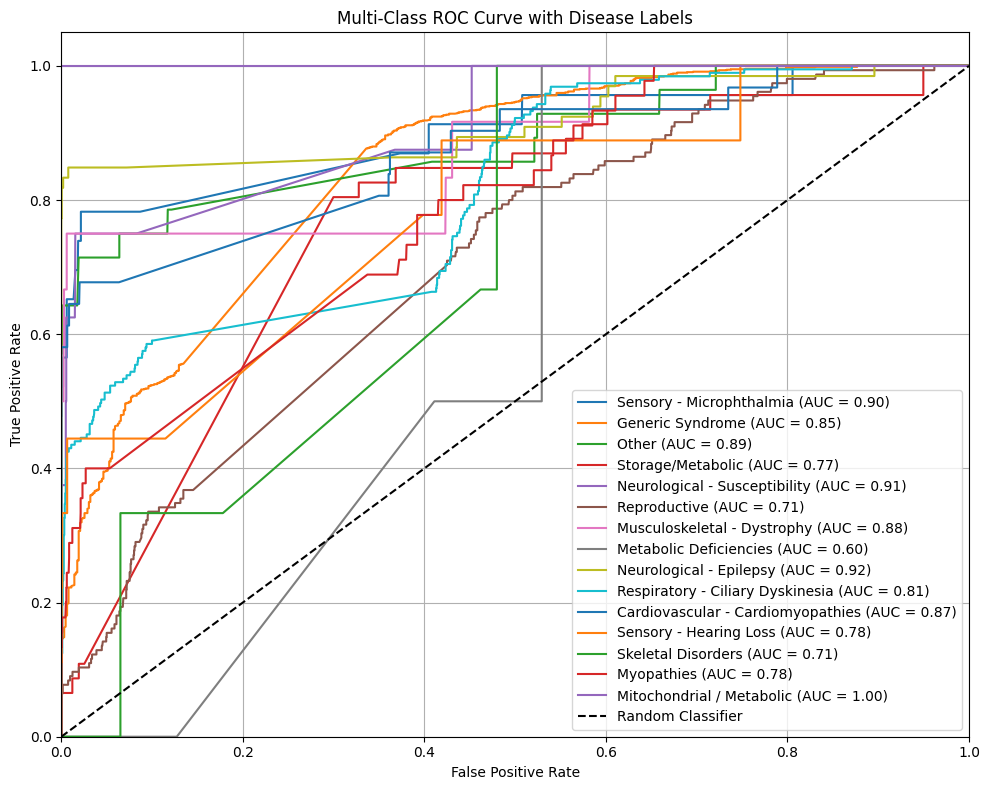

In [42]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Disease class names (replace with your actual labels)
class_names = [
    "Sensory - Microphthalmia",
    "Generic Syndrome",
    "Other",
    "Storage/Metabolic",
    "Neurological - Susceptibility",
    "Reproductive",
    "Musculoskeletal - Dystrophy",
    "Metabolic Deficiencies",
    "Neurological - Epilepsy",
    "Respiratory - Ciliary Dyskinesia",
    "Cardiovascular - Cardiomyopathies",
    "Sensory - Hearing Loss",
    "Skeletal Disorders",
    "Myopathies",
    "Mitochondrial / Metabolic"
]

# Binarize the output for multi-class ROC
y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
y_pred_prob = model.predict(x_test_pad)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve with Disease Labels")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

